# __TEAM RAVENS__
| __Name__ | __Registration Number__ | __Access Number__ | __Role__ |
|------|---------------------|---------------|----------|
|Lorraine Paula Arinaitwe|M23B38/004|B20729|Model training & Streamlit Integration|
|Rugogamu Noela|S23B38/016|B22775|Model training and evaluation, xAI & Fairness plus UI development|
|Ssendi Aloysious Malon|S23B38/002|B21258|Data Collection, Understanding and Pre processing& Cleaning as well as UI development|
# Notebook 2: Model Training and Evaluation

## Objective
This notebook focuses on:
1. Training 5 different machine learning models for Type 2 Diabetes prediction
2. Evaluating model performance using multiple metrics
3. Comparing models to select the best one
4. Saving the best model using joblib for deployment

## Models to Train
1. Logistic Regression
2. Random Forest
3. XGBoost
4. LightGBM
5. Support Vector Machine (SVM)


## Step 1: Import Required Libraries


In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model evaluation and hyperparameter tuning
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV, 
                                     StratifiedKFold)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)


## Step 2: Load Cleaned Data and Selected Features


In [2]:
# Load cleaned dataset
modelling_pima = pd.read_csv('../data/cleaned_diabetes_dataset.csv')

# Load selected features from Notebook 1
with open('../models/selected_features.json', 'r') as f:
    selected_features = json.load(f)

print("DATA LOADING")
print("_" * 60)
print(f"\nDataset shape: {modelling_pima.shape}")
print(f"\nSelected features ({len(selected_features)}):")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

# Prepare features and target
# Use selected features if available, otherwise use all numeric features except Outcome
if selected_features:
    X = modelling_pima[selected_features]
else:
    # Fallback: use all numeric features except Outcome
    numeric_cols = modelling_pima.select_dtypes(include=[np.number]).columns
    X = modelling_pima[numeric_cols.drop('Outcome')]

y = modelling_pima['Outcome']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nTarget distribution (%):")
print(y.value_counts(normalize=True) * 100)

DATA LOADING
____________________________________________________________

Dataset shape: (768, 13)

Selected features (9):
  1. Age
  2. BMI
  3. BloodPressure
  4. Glucose
  5. DiabetesPedigreeFunction
  6. PhysicalActivity
  7. DietQuality
  8. AlcoholUse
  9. Smoking

Features shape: (768, 9)
Target shape: (768,)

Target distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Target distribution (%):
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


## Step 3: Split Data into Training and Testing Sets


In [3]:
# Split data: 80% training, 20% testing
# stratify=y ensures both sets have similar class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("DATA SPLITTING")
print("_" * 60)
print(f"\nTraining set:")
print(f"  Features: {X_train.shape}")
print(f"  Target: {y_train.shape}")
print(f"  Class distribution:\n{y_train.value_counts().to_dict()}")

print(f"\nTesting set:")
print(f"  Features: {X_test.shape}")
print(f"  Target: {y_test.shape}")
print(f"  Class distribution:\n{y_test.value_counts().to_dict()}")


DATA SPLITTING
____________________________________________________________

Training set:
  Features: (614, 9)
  Target: (614,)
  Class distribution:
{0: 400, 1: 214}

Testing set:
  Features: (154, 9)
  Target: (154,)
  Class distribution:
{0: 100, 1: 54}


## Step 4: Comprehensive Hyperparameter Tuning

We'll perform intensive hyperparameter tuning for all 5 models using:
- GridSearchCV for exhaustive search (smaller parameter spaces)
- RandomizedSearchCV for efficient search (larger parameter spaces)
- Cross-validation to prevent overfitting
- Multiple evaluation metrics to select the best model

This ensures optimal model performance and realistic accuracy.


In [4]:
print("COMPREHENSIVE HYPERPARAMETER TUNING")
print("_" * 60)
print("Using 5-fold cross-validation to prevent overfitting.\n")

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store best models and their parameters
trained_models = {}
best_params = {}
tuning_results = {}

# Scoring metric for hyperparameter tuning (ROC AUC is most important for medical diagnosis)
scoring = 'roc_auc'

# ============================================================================
# 1. LOGISTIC REGRESSION - GridSearchCV
# ============================================================================
print("\n" + "=" * 60)
print("1. TUNING LOGISTIC REGRESSION")
print("=" * 60)

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [1000, 2000, 5000],
    'class_weight': [None, 'balanced']
}

# Use liblinear for l1/elasticnet, others for l2
lr_base = LogisticRegression(random_state=42)
grid_lr = GridSearchCV(
    lr_base, param_grid_lr, cv=cv, scoring=scoring, 
    n_jobs=-1, verbose=1, return_train_score=True
)

grid_lr.fit(X_train, y_train)

trained_models['Logistic Regression'] = grid_lr.best_estimator_
best_params['Logistic Regression'] = grid_lr.best_params_
tuning_results['Logistic Regression'] = {
    'best_score': grid_lr.best_score_,
    'best_params': grid_lr.best_params_
}

print(f"\nBest CV Score: {grid_lr.best_score_:.4f}")
print(f"Best Parameters: {grid_lr.best_params_}")

# ============================================================================
# 2. RANDOM FOREST - RandomizedSearchCV (faster for many parameters)
# ============================================================================
print("\n" + "=" * 60)
print("2. TUNING RANDOM FOREST")
print("=" * 60)

param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
random_rf = RandomizedSearchCV(
    rf_base, param_dist_rf, n_iter=100, cv=cv, scoring=scoring,
    n_jobs=-1, random_state=42, verbose=1, return_train_score=True
)


random_rf.fit(X_train, y_train)

trained_models['Random Forest'] = random_rf.best_estimator_
best_params['Random Forest'] = random_rf.best_params_
tuning_results['Random Forest'] = {
    'best_score': random_rf.best_score_,
    'best_params': random_rf.best_params_
}

print(f"\nBest CV Score: {random_rf.best_score_:.4f}")
print(f"Best Parameters: {random_rf.best_params_}")

COMPREHENSIVE HYPERPARAMETER TUNING
____________________________________________________________
Using 5-fold cross-validation to prevent overfitting.


1. TUNING LOGISTIC REGRESSION
Fitting 5 folds for each of 378 candidates, totalling 1890 fits

Best CV Score: 0.9510
Best Parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga'}

2. TUNING RANDOM FOREST
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best CV Score: 0.9606
Best Parameters: {'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 7, 'class_weight': None, 'bootstrap': False}


In [6]:
# ============================================================================
# 3. XGBOOST - RandomizedSearchCV
# ============================================================================
print("\n" + "=" * 60)
print("3. TUNING XGBOOST")
print("=" * 60)

param_dist_xgb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 1.5, 2, 2.5, 3]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
random_xgb = RandomizedSearchCV(
    xgb_base, param_dist_xgb, n_iter=150, cv=cv, scoring=scoring,
    n_jobs=-1, random_state=42, verbose=1, return_train_score=True
)


random_xgb.fit(X_train, y_train)

trained_models['XGBoost'] = random_xgb.best_estimator_
best_params['XGBoost'] = random_xgb.best_params_
tuning_results['XGBoost'] = {
    'best_score': random_xgb.best_score_,
    'best_params': random_xgb.best_params_
}

print(f"\nBest CV Score: {random_xgb.best_score_:.4f}")
print(f"Best Parameters: {random_xgb.best_params_}")

# ============================================================================
# 4. LIGHTGBM - RandomizedSearchCV
# ============================================================================
print("\n" + "=" * 60)
print("4. TUNING LIGHTGBM")
print("=" * 60)

param_dist_lgb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, -1],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves': [15, 31, 50, 70, 100, 127],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20, 30, 50],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0, 1.5],
    'class_weight': [None, 'balanced']
}

lgb_base = LGBMClassifier(random_state=42, verbose=-1)
random_lgb = RandomizedSearchCV(
    lgb_base, param_dist_lgb, n_iter=150, cv=cv, scoring=scoring,
    n_jobs=-1, random_state=42, verbose=1, return_train_score=True
)


random_lgb.fit(X_train, y_train)

trained_models['LightGBM'] = random_lgb.best_estimator_
best_params['LightGBM'] = random_lgb.best_params_
tuning_results['LightGBM'] = {
    'best_score': random_lgb.best_score_,
    'best_params': random_lgb.best_params_
}

print(f"\nBest CV Score: {random_lgb.best_score_:.4f}")
print(f"Best Parameters: {random_lgb.best_params_}")

# ============================================================================
# 5. SVM - GridSearchCV (with scaling)
# ============================================================================
print("\n" + "=" * 60)
print("5. TUNING SUPPORT VECTOR MACHINE (SVM)")
print("=" * 60)


# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],  # Only for poly kernel
    'class_weight': [None, 'balanced']
}

svm_base = SVC(probability=True, random_state=42)
grid_svm = GridSearchCV(
    svm_base, param_grid_svm, cv=cv, scoring=scoring,
    n_jobs=-1, verbose=1, return_train_score=True
)

grid_svm.fit(X_train_scaled, y_train)

# Store scaler with SVM model
trained_models['SVM'] = {
    'model': grid_svm.best_estimator_,
    'scaler': scaler
}
best_params['SVM'] = grid_svm.best_params_
tuning_results['SVM'] = {
    'best_score': grid_svm.best_score_,
    'best_params': grid_svm.best_params_
}

print(f"\nBest CV Score: {grid_svm.best_score_:.4f}")
print(f"Best Parameters: {grid_svm.best_params_}")



3. TUNING XGBOOST
Fitting 5 folds for each of 150 candidates, totalling 750 fits

Best CV Score: 0.9650
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.4, 'colsample_bytree': 0.6}

4. TUNING LIGHTGBM
Fitting 5 folds for each of 150 candidates, totalling 750 fits

Best CV Score: 0.9653
Best Parameters: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 70, 'n_estimators': 100, 'min_child_samples': 50, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.9, 'class_weight': None}

5. TUNING SUPPORT VECTOR MACHINE (SVM)
Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Best CV Score: 0.9642
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


In [7]:
# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING COMPLETE!")
print("=" * 60)
print("\nCross-Validation Scores (ROC AUC):")
for name, results in tuning_results.items():
    print(f"  {name:20s}: {results['best_score']:.4f}")


HYPERPARAMETER TUNING COMPLETE!

Cross-Validation Scores (ROC AUC):
  Logistic Regression : 0.9510
  Random Forest       : 0.9606
  XGBoost             : 0.9650
  LightGBM            : 0.9653
  SVM                 : 0.9642


## Step 5: Evaluate Models

We evaluate each model using multiple metrics:
- Accuracy: Overall correctness
- Precision: Of predicted positives, how many are actually positive
- Recall: Of actual positives, how many did we catch
- F1-Score: Harmonic mean of precision and recall
- ROC AUC: Area under the ROC curve (measures model's ability to distinguish classes)


In [10]:
# Evaluate all models on test set
results = []

print("=" * 60)
print("MODEL EVALUATION ON TEST SET")
print("=" * 60)

for name, model_info in trained_models.items():
    # Handle SVM which has scaler
    if name == 'SVM':
        model = model_info['model']
        scaler = model_info['scaler']
        X_test_eval = X_test_scaled
    else:
        model = model_info
        X_test_eval = X_test
    
    # Make predictions
    y_pred = model.predict(X_test_eval)
    y_pred_proba = model.predict_proba(X_test_eval)[:, 1]  # Probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Get CV score from tuning
    cv_score = tuning_results[name]['best_score']
    
    # Store results
    results.append({
        'Model': name,
        'CV Score (ROC AUC)': cv_score,
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1-Score': f1,
        'Test ROC AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  CV Score (ROC AUC):  {cv_score:.4f}")
    print(f"  Test Accuracy:       {accuracy:.4f}")
    print(f"  Test Precision:      {precision:.4f}")
    print(f"  Test Recall:         {recall:.4f}")
    print(f"  Test F1-Score:       {f1:.4f}")
    print(f"  Test ROC AUC:        {roc_auc:.4f}")

MODEL EVALUATION ON TEST SET

Logistic Regression:
  CV Score (ROC AUC):  0.9510
  Test Accuracy:       0.8571
  Test Precision:      0.7500
  Test Recall:         0.8889
  Test F1-Score:       0.8136
  Test ROC AUC:        0.9509

Random Forest:
  CV Score (ROC AUC):  0.9606
  Test Accuracy:       0.8961
  Test Precision:      0.8167
  Test Recall:         0.9074
  Test F1-Score:       0.8596
  Test ROC AUC:        0.9652

XGBoost:
  CV Score (ROC AUC):  0.9650
  Test Accuracy:       0.8896
  Test Precision:      0.8364
  Test Recall:         0.8519
  Test F1-Score:       0.8440
  Test ROC AUC:        0.9678

LightGBM:
  CV Score (ROC AUC):  0.9653
  Test Accuracy:       0.8831
  Test Precision:      0.8214
  Test Recall:         0.8519
  Test F1-Score:       0.8364
  Test ROC AUC:        0.9669

SVM:
  CV Score (ROC AUC):  0.9642
  Test Accuracy:       0.8961
  Test Precision:      0.8167
  Test Recall:         0.9074
  Test F1-Score:       0.8596
  Test ROC AUC:        0.9569


In [17]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test ROC AUC', ascending=False)

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print("\nModels sorted by Test ROC AUC (best to worst):")
print(results_df.to_string(index=False))

# Check for overfitting (CV score vs Test score)
print("\n" + "=" * 60)
print("OVERFITTING CHECK")
print("=" * 60)
print("\nComparing CV scores vs Test scores:")
for _, row in results_df.iterrows():
    diff = row['CV Score (ROC AUC)'] - row['Test ROC AUC']
    status = "Good" if abs(diff) < 0.05 else "Possible overfitting" if diff > 0.05 else "Underfitting"
    print(f"  {row['Model']:20s}: CV={row['CV Score (ROC AUC)']:.4f}, Test={row['Test ROC AUC']:.4f}, Diff={diff:+.4f} {status}")



MODEL COMPARISON SUMMARY

Models sorted by Test ROC AUC (best to worst):
              Model  CV Score (ROC AUC)  Test Accuracy  Test Precision  Test Recall  Test F1-Score  Test ROC AUC
            XGBoost            0.964964       0.889610        0.836364     0.851852       0.844037      0.967778
           LightGBM            0.965313       0.883117        0.821429     0.851852       0.836364      0.966852
      Random Forest            0.960619       0.896104        0.816667     0.907407       0.859649      0.965185
                SVM            0.964163       0.896104        0.816667     0.907407       0.859649      0.956852
Logistic Regression            0.951013       0.857143        0.750000     0.888889       0.813559      0.950926

OVERFITTING CHECK

Comparing CV scores vs Test scores:
  XGBoost             : CV=0.9650, Test=0.9678, Diff=-0.0028 Good
  LightGBM            : CV=0.9653, Test=0.9669, Diff=-0.0015 Good
  Random Forest       : CV=0.9606, Test=0.9652, Diff=-0.0046

In [15]:
results_df

,Model,CV Score (ROC AUC),Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test ROC AUC
2,XGBoost,0.964964,0.889610,0.836364,0.851852,0.844037,0.967778
3,LightGBM,0.965313,0.883117,0.821429,0.851852,0.836364,0.966852
1,Random Forest,0.960619,0.896104,0.816667,0.907407,0.859649,0.965185
4,SVM,0.964163,0.896104,0.816667,0.907407,0.859649,0.956852
0,Logistic Regression,0.951013,0.857143,0.750000,0.888889,0.813559,0.950926


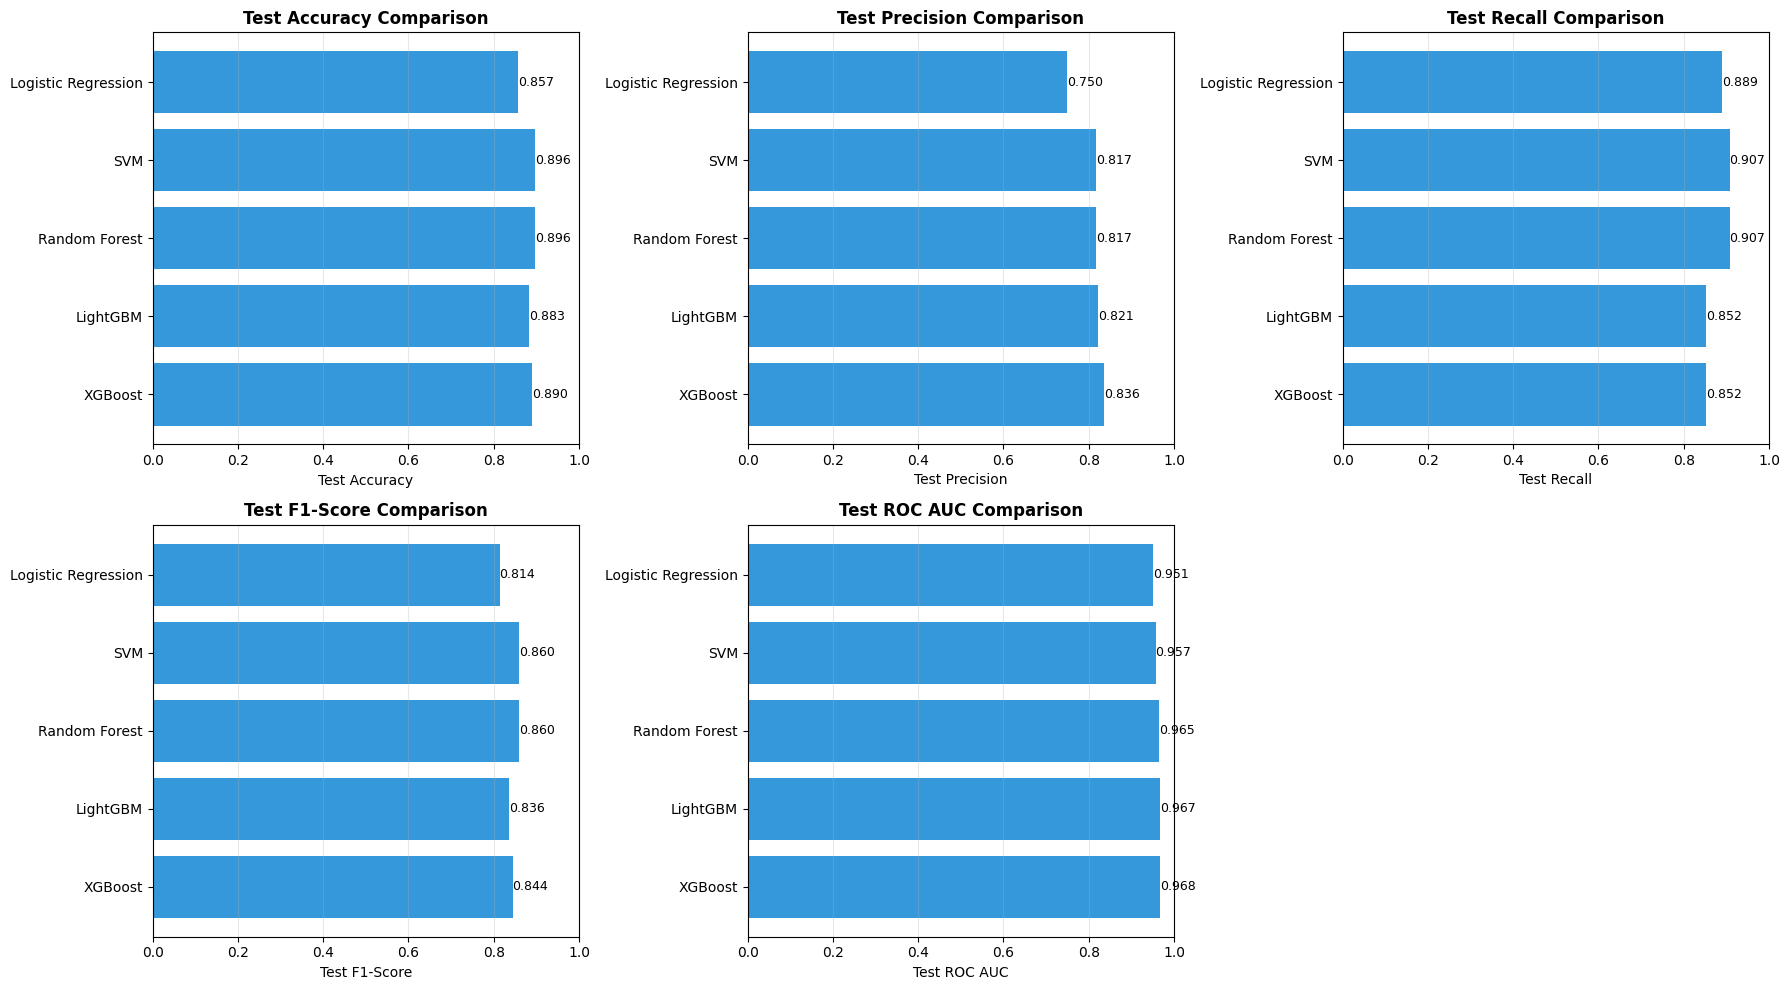

In [16]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Test Accuracy', 'Test Precision',
       'Test Recall', 'Test F1-Score', 'Test ROC AUC']

for idx, metric in enumerate(metrics):
    axes[idx].barh(results_df['Model'], results_df[metric], color='#3498db')
    axes[idx].set_xlabel(metric)
    axes[idx].set_title(f'{metric} Comparison', fontweight='bold')
    axes[idx].set_xlim([0, 1])
    axes[idx].grid(True, alpha=0.3, axis='x')
    # Add value labels
    for i, v in enumerate(results_df[metric]):
        axes[idx].text(v, i, f'{v:.3f}', va='center', ha='left', fontsize=9)

# Remove the last empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()


## Step 6: Select Best Model

We'll select the best model based on ROC AUC score (most important for medical diagnosis).

In [20]:
results_df.columns

Index(['Model', 'CV Score (ROC AUC)', 'Test Accuracy', 'Test Precision',
       'Test Recall', 'Test F1-Score', 'Test ROC AUC'],
      dtype='object')

BEST MODEL SELECTION

Best Model: XGBoost
ROC AUC Score: 0.9678

All metrics for best model:
  Test Accuracy: 0.8896
  Test Precision: 0.8364
  Test Recall: 0.8519
  Test F1-Score: 0.8440
  CV Score (ROC AUC): 0.9650

DETAILED CLASSIFICATION REPORT (Best Model)
              precision    recall  f1-score   support

 No Diabetes       0.92      0.91      0.91       100
    Diabetes       0.84      0.85      0.84        54

    accuracy                           0.89       154
   macro avg       0.88      0.88      0.88       154
weighted avg       0.89      0.89      0.89       154


CONFUSION MATRIX

True Negatives (TN): 91
False Positives (FP): 9
False Negatives (FN): 8
True Positives (TP): 46


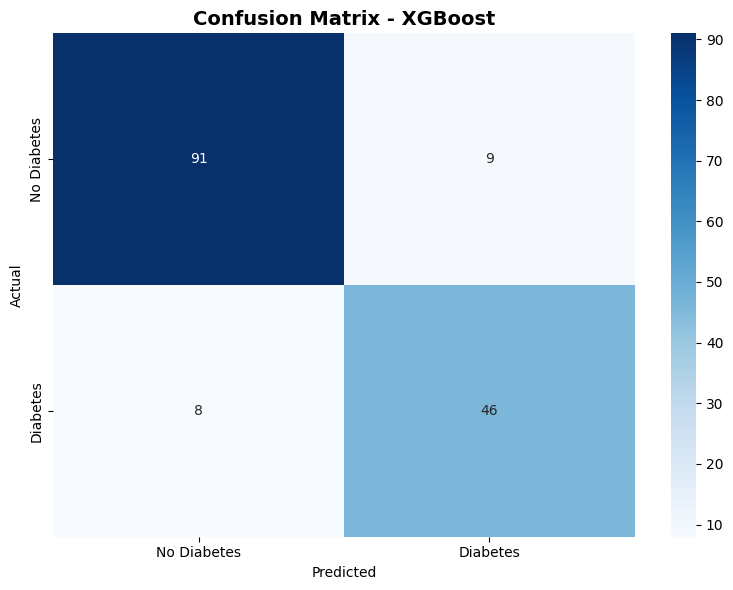

In [22]:
# Select best model based on ROC AUC
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_roc_auc = results_df.iloc[0]['Test ROC AUC']

print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"ROC AUC Score: {best_roc_auc:.4f}")

print(f"\nAll metrics for best model:")
best_metrics = results_df[results_df['Model'] == best_model_name].iloc[0]
for metric in ['Test Accuracy', 'Test Precision',
       'Test Recall', 'Test F1-Score', 'CV Score (ROC AUC)']:
    print(f"  {metric}: {best_metrics[metric]:.4f}")

# Generate detailed classification report for best model
y_pred_best = best_model.predict(X_test)
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT (Best Model)")
print("=" * 60)
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print(f"\nTrue Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Skipping SVM – it is not a fitted model (type: dict)


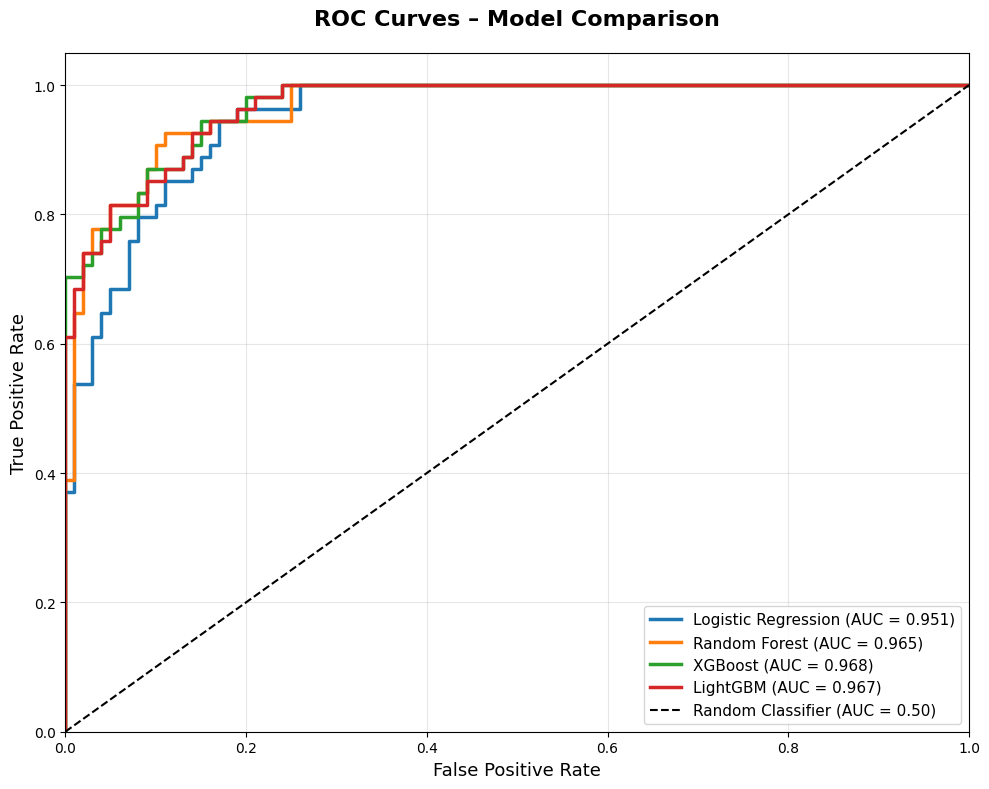

In [26]:
# ──────────────────────────────────────────────────────────────
# Plot ROC curves for all REAL models (skip dict entries)
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 8))

for name, obj in trained_models.items():
    # Only process objects that actually have predict_proba
    if not hasattr(obj, "predict_proba"):
        print(f"Skipping {name} – it is not a fitted model (type: {type(obj).__name__})")
        continue
    
    y_pred_proba = obj.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2.5)

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)', linewidth=1.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curves – Model Comparison', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Save Best Model

Saving the best model using joblib for use in the Streamlit application.


In [28]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best model
model_filename = '../models/best_model_pipeline.pkl'
joblib.dump(best_model, model_filename)

print("=" * 60)
print("MODEL SAVED")
print("=" * 60)
print(f"\nModel saved to: {model_filename}")
print(f"Model type: {best_model_name}")

# Also save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'features': selected_features,
    'metrics': {
        'accuracy': float(best_metrics['Test Accuracy']),
        'precision': float(best_metrics['Test Precision']),
        'recall': float(best_metrics['Test Recall']),
        'f1_score': float(best_metrics['Test F1-Score']),
        'roc_auc': float(best_metrics['Test ROC AUC'])
    },
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"\nModel metadata saved to: ../models/model_metadata.json")
print("\n✓ Model ready for deployment in Streamlit app!")


MODEL SAVED

Model saved to: ../models/best_model_pipeline.pkl
Model type: XGBoost

Model metadata saved to: ../models/model_metadata.json

✓ Model ready for deployment in Streamlit app!
